In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
df = pd.read_csv('data/4020177.csv')
df.head

<bound method NDFrame.head of            STATION                      NAME        DATE  PRCP  SNOW  SNWD  \
0      USC00198368  NWS BOSTON NORTON, MA US    7/1/1994  0.00   0.0   NaN   
1      USC00198368  NWS BOSTON NORTON, MA US    7/2/1994  0.00   0.0   NaN   
2      USC00198368  NWS BOSTON NORTON, MA US    7/3/1994  0.00   0.0   NaN   
3      USC00198368  NWS BOSTON NORTON, MA US    7/4/1994  0.00   0.0   NaN   
4      USC00198368  NWS BOSTON NORTON, MA US    7/5/1994  0.00   0.0   NaN   
...            ...                       ...         ...   ...   ...   ...   
10357  USC00198368  NWS BOSTON NORTON, MA US  11/10/2022  0.00   0.0   0.0   
10358  USC00198368  NWS BOSTON NORTON, MA US  11/11/2022  0.00   0.0   0.0   
10359  USC00198368  NWS BOSTON NORTON, MA US  11/12/2022  0.54   0.0   0.0   
10360  USC00198368  NWS BOSTON NORTON, MA US  11/13/2022  0.12   0.0   0.0   
10361  USC00198368  NWS BOSTON NORTON, MA US  11/14/2022  0.19   0.0   0.0   

       TMAX  TMIN  TOBS  WESD  WE

In [2]:
df.apply(pd.isnull).sum()

STATION        0
NAME           0
DATE           0
PRCP           0
SNOW           2
SNWD        4786
TMAX          51
TMIN          59
TOBS        5354
WESD        8745
WESF        8891
WT01       10215
WT03       10213
WT04       10330
WT05       10351
WT06       10355
WT11       10359
dtype: int64

In [3]:
core_weather = df[["PRCP","TMAX","TMIN"]].copy()

In [4]:
core_weather.columns = ["Rain","Temp_max","Temp_min"]

In [5]:
core_weather

,Rain,Temp_max,Temp_min
0,0.00,83.0,64.0
1,0.00,84.0,58.0
2,0.00,83.0,64.0
3,0.00,84.0,62.0
4,0.00,82.0,53.0
...,...,...,...
10357,0.00,53.0,32.0
10358,0.00,69.0,43.0
10359,0.54,71.0,51.0
10360,0.12,73.0,51.0


In [6]:
core_weather = core_weather.fillna(0)

In [7]:
core_weather

,Rain,Temp_max,Temp_min
0,0.00,83.0,64.0
1,0.00,84.0,58.0
2,0.00,83.0,64.0
3,0.00,84.0,62.0
4,0.00,82.0,53.0
...,...,...,...
10357,0.00,53.0,32.0
10358,0.00,69.0,43.0
10359,0.54,71.0,51.0
10360,0.12,73.0,51.0


In [8]:
core_weather["target"] = core_weather.shift(-1)["Temp_max"]

In [9]:
core_weather["target"]

0        84.0
1        83.0
2        84.0
3        82.0
4        91.0
         ... 
10357    69.0
10358    71.0
10359    73.0
10360    51.0
10361     NaN
Name: target, Length: 10362, dtype: float64

In [10]:
reg = Ridge(alpha=.1)

In [11]:
predictors = ["Rain","Temp_max","Temp_min"]

In [12]:
train = core_weather.loc[:"9000"]
test = core_weather.loc["9000":]

In [13]:
reg.fit(train[predictors],train["target"])

Ridge(alpha=0.1)

In [14]:
prediction = reg.predict(test[predictors])

In [15]:
combined = pd.concat([test["target"], pd.Series(prediction, index=test.index)], axis=1)
combined.columns = ["actual","prediction"]

In [16]:
combined

,actual,prediction
9000,43.0,48.630577
9001,41.0,44.681515
9002,46.0,44.214429
9003,37.0,47.850235
9004,30.0,40.816045
...,...,...
10357,69.0,53.716385
10358,71.0,67.192819
10359,73.0,69.631823
10360,51.0,71.817759


<Axes: >

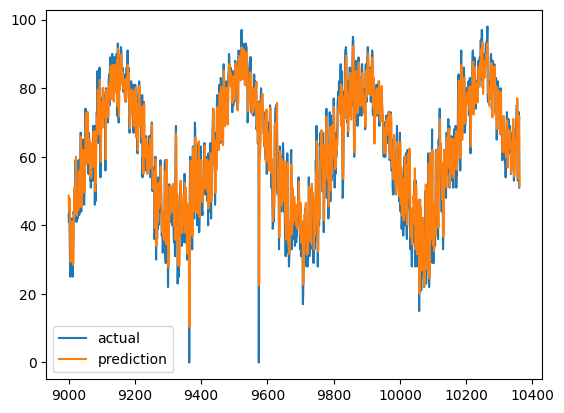

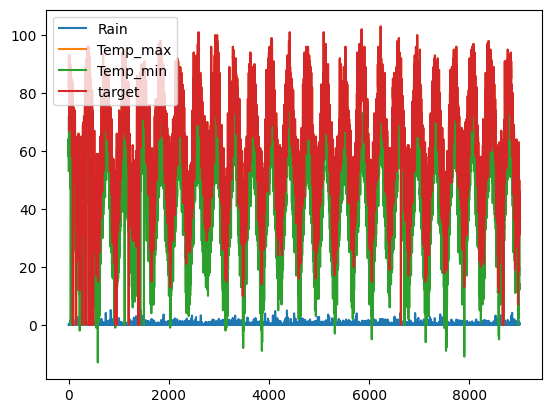

In [17]:
combined.plot()
core_weather.loc[:'8999'].plot()
#plt.xlim([10300, 10361])

<Axes: >

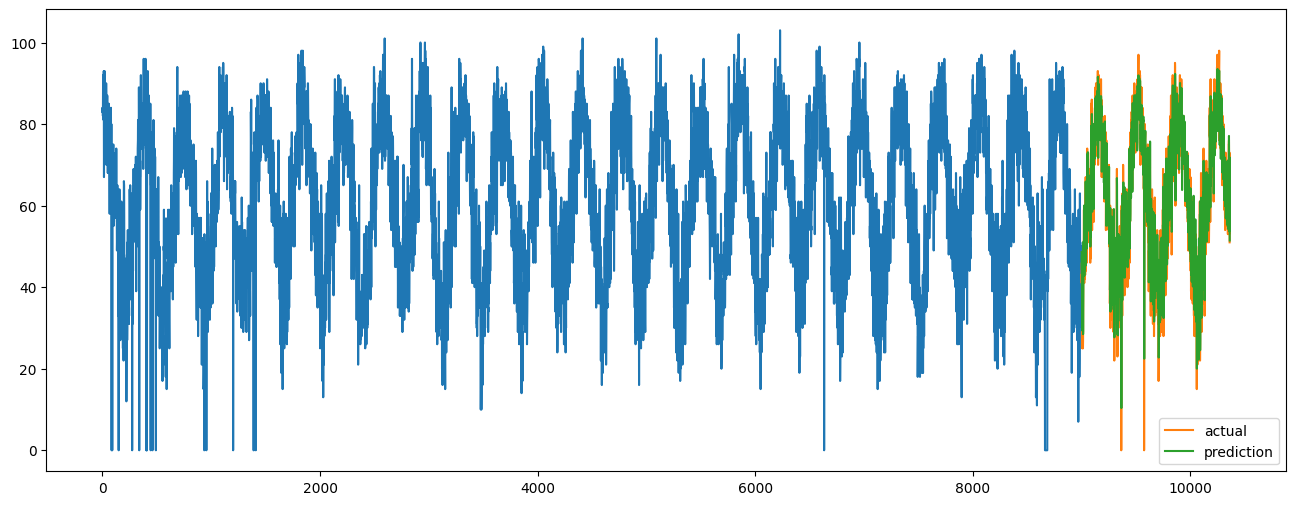

In [18]:
ax = core_weather.loc[:'8999','Temp_max'].plot(figsize=(16, 6), label="core_weather")
combined.plot(ax=ax, label=["actual", "prediction"])

In [19]:
valid_combined = combined.dropna()

# Extract cleaned actual and predicted values
y_true = valid_combined["actual"]
y_pred = valid_combined["prediction"]

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"Prediction MAE: {mae:.3f}")
print(f"Prediction MSE: {mse:.3f}")
print(f"Prediction RMSE: {rmse:.3f}")
print(f"Prediction R² Score: {r2:.3f}")

Prediction MAE: 5.957
Prediction MSE: 62.252
Prediction RMSE: 7.890
Prediction R² Score: 0.800


In [20]:
X_train = train.drop(columns=["target"])
y_train = train["target"]
y_train_pred = reg.predict(X_train)

In [21]:

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print(f"Training MAE: {mae_train:.3f}")
print(f"Training RMSE: {rmse_train:.3f}")
print(f"Training R²: {r2_train:.3f}")

Training MAE: 6.447
Training RMSE: 8.770
Training R²: 0.793
